# Thymio Project

# Thymio Project
double title???
## Groupe
* Sven Norbert Becker (337372), sven.becker@epfl.ch
* Olivier Deforche (342490), olivier.deforche@epfl.ch
* Nicolaj Schmid (269552), nicolaj.schmid@epfl.ch
* Ekrem Yüksel   (343742), ekrem.yuksel@epfl.ch

## Introduction
In this project, different algorithms seen in the course _Basics of Mobile Robotics_ (MICRO-452, EPFL) are implemented on a _Thymio_ robot. The general goal is to let Thymio find the way, from his current position to a destination. On the way Thymio has to cross a flat field filled with obsticals. The rectangular field is defined by four QR-codes that mark the corners. The origin of this field is defined by the marker on the bottom left. The x- and y-axis are given by the QR-codes on the bottom right and top left respectively. The pose of the robot is defined by the angle between the x axis and its orientation. Thymio can be placed anyware on the field as starting point. Then, the Python program is started and finds the optimal way to the destination that is defined by a fifth QR-code. The script ran on the computer moves Thymio autonomiously around obstacles. In the mean time, it is possible that additional dynamic obsticals are added to the field and Thymio needs to be able to move around them. To fulfill these tasks, Thymio has several on board sensors, for example the proximity sensors and the motor speed sensors. Additionally, an external webcam is used for global orientation.

>Add picture with field, QR-codes and obsticals ??? I will also rewrite a bit???

## Overview
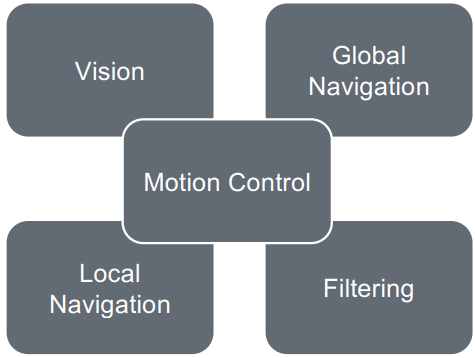

In general, the project can be split into five parts as shown in the figure above. Each module is described briefely in the following to have a rough idea how the project is implemented. Please find closer descriptions of each part in the following chapters.
1. For the vision, the field defined by four QR-codes is analyzed. With the help of the camera a map with Thymio's starting position, the destination and all obsticals is created. This information is passed over to the global navigation.
>* Inputs: picture from camera
>* Outputs: (???please specify???)
>* Code: (??? class name of module???)
>* External libraries: (???add Python libraries???)

2. Using the map created by the vision part, the global navigation calculates the optimal path from Thymio's starting point to the destination. This is done with help of a visability graph. The optimal path is described by a sequence of nodes Thymio has to follow. This sequence is handed over to the motion controller.
>* Inputs: matrix showing connectivity and list of coordinates of all nodes
>* Outputs: List of coordinaties of the respective nodes to follow  
>* Code: getTrajectory()
>* External libraries: Dijkstar

3. The motion controller is the heart of the entire program. It recieves a sequence of nodes from the global navigation and executes the corresponding movments. At every updating cycle the motion controller asks the kalman filter for a position estimation. Also, the uncertainty estimation of the estimated position is verified. If this uncertainty exceeds a certain threshold the vision part is re-triggered, a new picture is taken and the measured position is given back to the kalman filter to correctify the estimation. The controller also manages the local navigation making use of an additional state, which is triggered when the distance sensor pick up any signal. 
>* Inputs: list of nodes of the optimal path
>* Outputs: motor speeds $\dot\phi_L, \dot\phi_R$ 
>* Code: class _Controller_
>* External libraries: None

4. The Kalman filter makes permanently estimations about Thymio's position. When asked, this estimation is provided for the motion controller which uses it for navigating. The Kalman filter runs in parallel (in seperat thread) to the main program and is updated at higher frequency. Only the speed sensors are used inside the Kalman filter. However, if the estimation uncertainty becomes too large the motion controller gives a position measurement from the camera to the filter which is merged with the speed measurements.
>* Inputs: speed measurement from motors: [left speed, right speed], position measurment from camera: [x position, y position, angle]
>* Outputs: state vector for motion controller: [x position, y position, angle, x velocity, y velocity, angular velocity], uncertainty estimation: [covariance matrix of state vector]
>* Code: class _KalmanFilter_, class _RepeatedTimer_
>* External libraries: class _ClientAsync_ from _tdmclient_

The following libraries are used in multiple modules and only listed here: _math.py_, _time.py_, _numpy.py_, _matplotlib.py_

## 1) Vision

### Introduction
The Vision module is used to track the robot’s pose throughout runtime and to create a visibility graph with the Thymio and the goal at the beginning of our software-startup. After image-acquisition from the given Webcam “Aukey W1”, ArUco-markers defining the corners of the rectangular ground-plane are detected and used to transform the image so that it equals the ground-plane. One pixel in the transformed image corresponds to one millimeter in reality. In this image, we can once again extract the position of ArUco-markers corresponding to robot and goal respectively. At this point, Thymio’s pose is already available. Further image processing allows the binary and pixel-wise segmentation of obstacles from the ground-plane. The obstacles are then approximated with polygons, which are expanded considering the geometric size of the Thymio-robot and permissible errors in motion-control. Their corners represent nodes in the visibility graph and exhaustive line-checking ensures that no edge lies within the union of all polygons. This process is detailed on an example below.

The implementation is built around the open-source computer vision software OpenCV (https://opencv.org/). The geometric calculations are done with the `shapely` python package (https://github.com/shapely/shapely).
Our application relies heavily on the use of ArUco-markers since high performant detection algorithms are available. The markers have been created with the web-tool on https://chev.me/arucogen/. 


### Description of Setup and Preparatory Steps

#### Ground-Plane
We must first specify the ground plane of our application prior to software-startup. Four AruCo-markers placed in a rectangular fashion are the border points of our set-up. The markers are drawn from the 4x4-ArUco-dictionary and have the counter-clockwise increasing IDs 0-1-2-3. These markers define the world-frame of our application, with the x-axis being the normalized vector from the centers of markers 0 to 1 and the y-axis from 0 to 3; the origin lies at marker 0’s center. During this process, the lengths of the rectangle’s edges must be measured in millimeters and set in the Vision-module’s class-constants GROUND_PLANE_X/Y_MM manually. The markers can be oriented arbitrarily – only their position matters. Within the limits of the camera’s resolution and field-of-view, arbitrarily sized ground planes are possible. 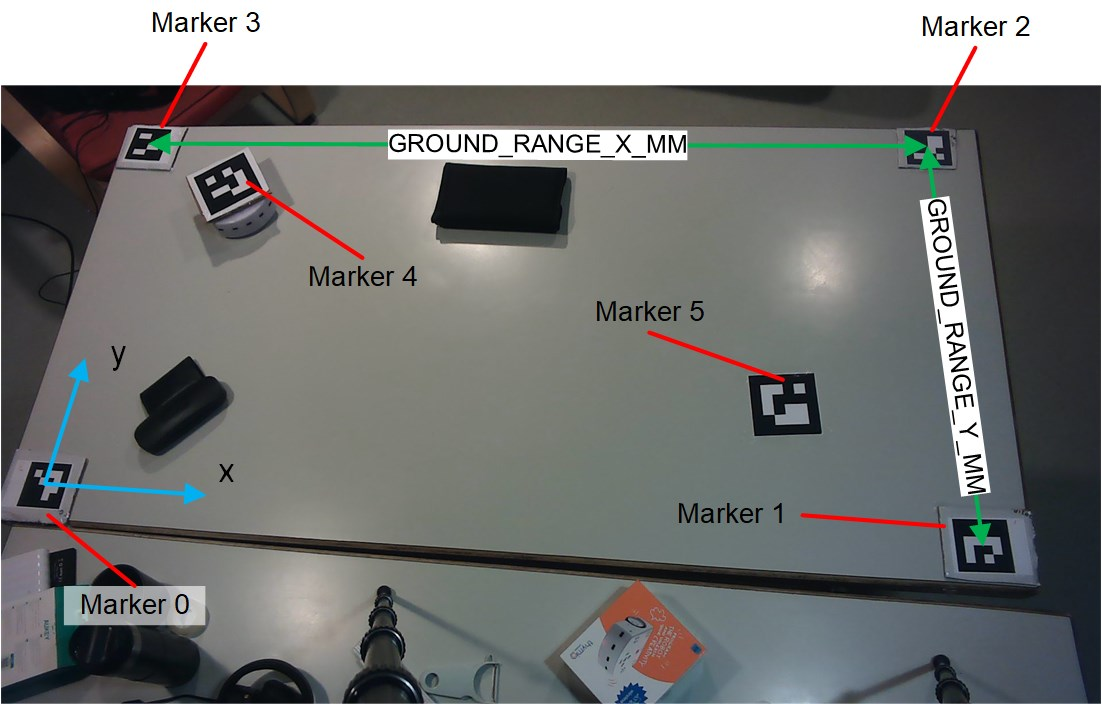

#### Thymio and Goal
For sake of simplicity, Thymio and goal are equipped with ArUco-markers as well. Just as the ground-plane, we draw them from the 4x4-dictionary and use the IDs 4 and 5 respectively. While the orientation of the goal’s marker is meaningless, the one on the Thymio must be placed such that the marker’s center equals the center of Thymio’s hole between the wheels and the two squares of the ID-4-marker are at its back to track the heading. wHY THE SECOND PICUTRE IF IT IS FOR THE GOAL, IT IS A BIT UNCLEAR???


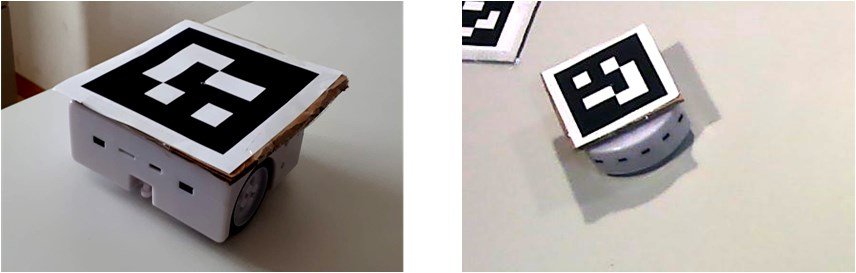

#### Obstacles
Obstacles are objects that are darker than the ground-plane. To adapt the algorithm for different application environments, one class-constant-parameter (BINARIZATION_THRESHOLD) must be set through testing. By running directly the Vision.py-file, one continuously obtains the output of the complete pipeline, i.e. a visibility graph. The user can manipulate the mentioned parameter until good results are obtained with one test-obstacle that similar specular characteristics as the obstacles used during runtime.

#### Camera Calibration
The purpose of this step lies in the imperfection of our acquisition-system: Since our webcam is not a precise instrument, distortions occur in the image, i.e., straight lines in reality appear as arcs in the image plane, which is not acceptable for accurate robot-tracking and obstacle-detection. Mathematical models describing this effect exist in OpenCV and can also be utilized to compensate for it. The corresponding model parameters must be calculated from calibration data. This is done by capturing a specific-sized test pattern in various poses with the camera and then running an algorithm yielding the optimal set of parameters for the provided calibration-images. In our case, a calibration implementation with a ChArUco-board (a mixture of checkerboard and ArUco markers) created on https://calib.io/pages/camera-calibration-pattern-generator as test pattern was used following the tutorial in https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/sandbox/ludovic/aruco_calibration_rotation.html. Unlike the tutorial, the simplest camera model consisting of 2 parameters for radial and 3 parameters for tangential distortion and a standard camera matrix (4 parameters) was targeted in our case to avoid overfitting (https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html). The parameters are stored locally in a yaml-file for easy re-use and must only be updated when changing the acquisition system.
<br>_Note: After calibration, it is theoretically possible to track the spatial 6D-pose of an ArUco marker of known size. However, despite tedious calibration attempts, the given webcam seems to be too imprecise for absolute marker-tracking as offsets from real to tracked pose range up to 10 cm which renders this approach unusable in this application._

WHAT IS THE 6d POSE???

### Step-by-Step Guide through Vision-Pipeline
The functioning of the vision system is explained best by going incrementally through the processing steps. To demonstrate the steps of the pipeline, an exemplary image taken with the webcam in a similar setting as during deployment is processed here. The ground-plane was measured to be 1450x700mm. NOT SHOWING UP???

In [1]:
!pip install shapely
!pip install opencv-contrib-python

In [2]:
# Load vision module
from Vision.Vision import Vision

# Load demo-image and comprison-tool
from Figures.plotBeforeAfter import plotBeforeAfter
import cv2 as cv
demo_img = cv.imread("./Figures/demo.jpeg")

TypeError: 'type' object is not subscriptable

#### Instantiation
At instantiation of the Vision-module, the user must specify which input source to select by its non-negative ID-integer in the computer system. It is then opened in full-HD mode for maximum performance. For demonstration purposes, a “-1” can be passed so that the vision class works with a given image instead of captured webcam data.
Also, the calibration file (“calibration.yaml”) is loaded with the 9 correction parameters for the specific webcam.

In [ ]:
v = Vision(-1)

#### Image Acquisition
To acquire an image, one must call the `acquireImg`-method. In this process, we can apply the distortion correction of the acquired image. Compare the ‘straightness’ of lines to see the effect of un-distortion.

In [ ]:
undistorted_img = v.acquireImg(undistort=True, demo_img=demo_img)
plotBeforeAfter(demo_img, undistorted_img, [False, False])

#### Warp Transformation
The next step is to transform the captured image so that the output image equals the ground-plane with one pixel corresponding to one millimeter in reality. The first step is to detect the boundary-ArUco-markers using boilerplate-code from https://machinelearningknowledge.ai/augmented-reality-using-aruco-marker-detection-with-python-opencv/, which yields inter alia 1 ID and 4 corner points per detected marker. The actual border points are then extracted as the centroids of the marker’s corners obtained through the arithmetic mean of all it’s 4 corner points. Note that we are in pixel-coordinates. With the given convention detailed above, we can map each centroid-coordinate to the corner of the transformed image as detailed in the table below. The centroid-coordinates are at pixel-values corresponding to the marker’s position in the mentioned reference frame. From this mapping, OpenCV calculates a 3x3-matrix $T$ that can directly be used to warp a captured image into the plane-representation : $(t_i x'_i, t_i y'_i, t_i)^\top=T(x_i,y_i,1)^\top$ with $x_i,y_i$ as pixels from the original image and $x'_i,y'_i$ as their mapped counterparts in the new image (https://docs.opencv.org/4.x/da/d54/group__imgproc__transform.html#ga20f62aa3235d869c9956436c870893ae).
Since the markers with their black pattern resemble obstacle objects, they should be overdrawn by a white polygon during this step to minimize confusions in further steps. In the implementation, the method `extractWarp` extracts the transformation matrix whereas method `applyWarp` applies it.

| Marker ID 	| Mapped Pixel Coordinate                 	|
|:----------	|---------------------------------------:	|
|         0 	| (0,0)                                  	|
|         1 	| (GROUND_PLANE_X_MM, 0)                 	|
|         2 	| (GROUND_PLANE_X_MM, GROUND_PLANE_Y_MM) 	|
|         3 	| (0, GROUND_PLANE_Y_MM)                 	|

In [ ]:
before = undistorted_img.copy()
_, overdrawn_ground_markers_img, warp_transform = v.extractWarp(img=undistorted_img, remove_border_aruco=True)
warped_image = v.applyWarp(img=overdrawn_ground_markers_img, warp_transform=warp_transform)
plotBeforeAfter(before, warped_image, [False, True])

#### Thymio and Goal Finding
The following Thymio- and goal-finding methods (`findThymio` and `findGoal` respectively) are very similar and must be applied to the ‘plane’-image resulting from the previous step. The metric position in millimeter of Thymio and goal equals to the pixel-coordinates of their marker’s centroid due to our specific warp-transform the previously. To obtain the Thymio’s heading, we calculate the angle of the vector between 2 corner points of the marker and the frame’s x-axis. This is once again simple due to the warp-transform and the specific orientation of the marker on Thymios’s top. Thymio’s and the goal’s marker can as well be overdrawn by a white polygon for confusion-avoidance. Additionally, there exists a more sophisticated overdraw-option for the Thymio since depending on the illumination, the robot might cast shadows that can be confused with obstacles. This option therefore covers the Thymio generously with a white polygon to mitigate this problem. However, this aggressive approach is not necessary most light conditions.

In [ ]:
before = warped_image.copy()
_, overdraw_thymio_img, thymio_pose = v.findThymio(img=warped_image, marker_id=4, remove_thymio="marker")
_, all_aruco_overdrawn_img, goal_position = v.findGoal(img=overdraw_thymio_img, marker_id=5)
visualization_img = v.prepareForVisualization(img = all_aruco_overdrawn_img.copy(), visibility_graph=None, optimal_path=None, thymio_pose=thymio_pose, goal_pos=goal_position)
plotBeforeAfter(before, visualization_img)

#### Obstacle Segmentation
In preparation of the visibility graph, the image is segmented into obstacle and non-obstacle regions in the `obstacleSegmentation`-method. Here, we first use a Contrast Limited Adaptive Histogram Equalization (CLAHE) on the grayscale ‘plane’-image to increase the contrast of the image. CLAHE is chosen instead of the standard equalization approach to account for local illumination changes across the ground plane (https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html). A bilateral filter is then applied since it smooths the image while preserving the edges of our obstacle objects. Morphological operations are then applied to the binarized output of these steps. Firstly, the image is closed to remove small artefacts that do not represent obstacles but noise. The kernel-width is 25 pixels, i.e., dark objects smaller than 25x25mm are classified as noise. Secondly, the image in opened with a 51-pixel/mm-kernel to account for the fact that in rare cases, obstacle objects have a bright spot within them due to their specular properties. One can observe this phenomenon at the etui of our example-image in the bottom left corner. In this specific example, the bright spot is too close to the edge of the obstacle (distance < 25mm). Therefore, parts of the obstacle are removed in the closing operation resulting in the white spike in the segmented image. In contrast, the bright spot on the purse just behind the etui was classified correctly.
The settings for the filters have been found through various experiments. To adapt this process for different illumination settings quickly, it is sufficient to only adapt the BINARIZATION_THRESHOLD. 

In [ ]:
before = all_aruco_overdrawn_img.copy()
segmented = v.obstacleSegmentation(img=all_aruco_overdrawn_img)
plotBeforeAfter(before, segmented)

#### Polygon Extraction
The obstacles in the segmented image are approximated with polygons in the `getContourPolygons` emthod. Therefore, we first apply a contour-detection algorithm. Since we target arbitrarily shaped obstacles and the borders of the segmented obstacles are subject to noise, we apply the Douglas-Peucker algorithm to approximate the contour by straight lines. As the epsilon, we chose a value proportional to the contour’s arc length in accordance with OpenCV’s guide in https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html and tuned the multiplier for our use case. The lines are then converted into shapely-polygons for simple geometric processing. It is common practice to expand those polygons by the robot’s size and the maximum permissible error from motion control. Therefore, the visibility graph built on those expanded polygons is guaranteed not to cause any collisions of the robot with the obstacles.

In [ ]:
polygons = v.getContourPolygons(img=segmented, buffer_mm=150)
visualization_img = v.prepareForVisualization(before.copy(), visibility_graph=None, polygons=polygons, thymio_pose=None, goal_pos=None)
plotBeforeAfter(before, visualization_img)

#### Visibility Graph
In the final step of the vision-pipeline (`visibilityGraph`-method), the visibility graph is obtained. The set of nodes is the set of corner points from all polygons, usually expanded by Thymio’s and the goal position. Through expansion of polygons in the previous step, corner points might lie outside of the ground plane (e.g., have a negative coordinate). Those are infeasible and therefore omitted here. Through combinatorics, we create potential edges between every possible combination of 2 different points and check if this edge lies within the union of all obstacle-polygons. The result is manifested in a binary adjacency matrix. Since the graph is undirected, the matrix is made symmetric through addition of its transposed.

In [ ]:
adj_matrix, points = v.visibilityGraph(polygons=polygons, reset_obstacle_map=True,goal_pose=goal_position,thymio_pose=thymio_pose)
visualization_img = v.prepareForVisualization(before.copy(), visibility_graph=[adj_matrix, points], polygons=polygons, thymio_pose=None, goal_pos=None)
plotBeforeAfter(before, visualization_img)

## Shortest Path Computation
### Theory
Once the visibility graph is found, Dijkstra's extended algorithm is used to compute the shortest path for the Thymio to reach the goal. Dijkstra's extended algorithm is chosen to ensure good perfermance for larger playing fields with a high number of obstacles compared to the original Dijkstra's algorithm. A* maintains a tree of paths originating at the start node and extending those paths one edge at a time until its termination criterion is satisfied. At each iteration of its main loop, the algorithm needs to determine which of its paths to extend. It does so based on the cost of the path and an estimate of the cost required to extend the path all the way to the goal. Specifically, A* selects the path that minimizes

$f(n)=g(n)+h(n)$

where n is the next node on the path, g(n) is the cost of the path from the start node to n, and h(n) is a heuristic function that estimates the cost of the cheapest path from n to the goal. For this application, the cost of the path is defined as the distance between the current and next node, and the heuristic function is defined as the distance between the next node and the goal. However, for smaler playing fiels the heuristic function is not used, since in some cases it does not offer the optimal path.  

### Code
To implement A*, the functions Graph and find_path from the 'Dijkstar' library are used to create the graph and find the optimal path using the heuristics function. As input, 2 matrices (output of the visibility part) are used. The first one, A, showing the connectivity between each node (1=connected, 0=not connected) with the number one referring to the Thymio and the final number referring to the goal. The other matrix, B, is a tuple of every node in the graph with its respective x- and y-coordinate. The algorithm returns a list of the coordinates of the to follow nodes to reach the goal. The code is shown below for the same test case as displayed in the image from the vision section (red line = optimal path). 

In [ ]:
!pip install dijkstar

In [ ]:
from dijkstar import Graph, find_path
import math

# Test case: output of the code from the vision part  
A = [[0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]]
B = [(111.75, 308.25), 
     (273.48433987, 364.79555652), 
     (283.04082542, 398.92586205), 
     (382.1554383 , 383.67746007), 
     (417.76361232, 350.80837636), 
     (408.32829403, 132.44815304), 
     (271.48369722, 130.8382166 ), 
     (236.66422046, 157.92003186), 
     (229.79945072, 358.37130811),
     (273.48433987, 364.79555652), 
     (576, 281)]

# Calculation of the euclidean distance between each 2 nodes that can reach each other
for i in range(0,len(A)):
  for j in range(0,len(A)):
      if A[i][j] !=0:
        A[i][j] = math.sqrt((B[j][0]-B[i][0])**2 + (B[i][1]-B[j][1])**2)



# Heursitic function: eucledian distance between node and goal 
# with u= current node, v= next node, edge= edge that connects u to v, and prev_edge= edge that was traversed previously.
def heuristic_func(u, v, edge, prev_edge):
  length_to_goal = math.sqrt((B[v][0]-B[-1][0])**2 + (B[v][1]-B[-1][1])**2)
  return length_to_goal

# Initialise graph
graph = Graph()
for i in range(0,len(A)):
  for j in range(0,len(A)):
    if A[i][j] != 0:
      graph.add_edge(i, j, A[i][j])

# Find the optimal path 
# with outputs nodes= optimal path, edges= optimal edges, costs= the costs (here equal to the edges) 
# and total_cost= the total cost of the optimal path (in distance)
nodes, edges, costs, total_cost = find_path(graph, 0, len(A)-1, heuristic_func=heuristic_func)
print('Nodes to for optimal path:',nodes)
print('Edges:', edges)
print('Costs:',costs)
print('Total cost:', total_cost)

# Change the nodes vector to a vector with the respective coordinates to follow.
points = list()
for point in nodes:
    points.append([B[point][0], B[point][1]])

print('Coordinates to follow for optimal path:',points)

## Kalman Filter
### Objective
The principal task of the Kalman filter is to povide a good estimation about the position (x and y position in the global reference frame) and the pose (angle with respect to the x-axis) of the Thymio and to make some sensor fusion between motor speed measurements and positional measuremets

### Integration
The entire filter is implemented inside the class _KalmanFilter_. Kalman filter assume a linear system. To reduce the linearization error it is good to update the filter at highest frequency possible. Therefore, we decided that the kalman filter should run in a different thread than the main loop. In the main an instance from the class _RepeatedTimer_ must be created. This object uses the _Timer_ class of python's _threading_ library and calls _KalmanFilter.update_filter_ at 10Hz. The auther public functions of _KalmanFilter_ are _KalmanFilter.get_state_vector_, _KalmanFilter.get_covariance_matrix_ and _KalmanFilter.set_position_measurement_. Except when calling these functions the Kalman filter runs totally independent from the rest of the code. The two getter functions provide the estimated state vector [x position, y position, angle, x velocity, y velocity, angular velocity] and the uncertainty estimation (covariance matrix of state vector).

### Measurements
One main advantage of the Kalman filter is its capability to fuse multiple measurements coming from different sensors. In the case of our project, Thymio's motor speed sensors were taken as on board sensors and the camera as external measurement source. Our goal was to use the external localisation ie. the camera as few as possible. This choice was done because in real world application it is easy possible that a robot looses connection to external positioning systems as for example the GPS. Therefore, the Thymio should be able to run as long and as precise as possible just with the speed measurements. However, the speed sensors introduce a lot of noise into the system and do not consider for example the slipping of the wheels. Hence, the "unprecision" of the filter must be estimated somehow which is done by calculating the covariance matrix of the state vector. The filter assumes that all noise is Gaussian. By an eigenvalue analysis we can calculate the standard deviation of the uncertainty in the worst direction ie. how good the estimation is supposed to be. Out of simplicity, only the uncertainty of the position is considered (and not the one of the pose, velocity or rotation). As shown in equation 1, we take the second standard deviation because then we have a probability of over 95% to be in the given distance from the estimated position:

\begin{equation*}
2\sigma_{max} = 2*\sqrt{max(|eigenvalues|)}
\label{eq:eigenvalues} \tag{1}
\end{equation*}

As soon the second standard deviation exceeds a certain freshold the motion controller will ask the camera to take another picture and feed this position measurement back to the Kalman filter. This is done by the setter function _KalmanFilter.set_position_measurement_. The position measurment by the camera has a much lower uncertainty than the speed measurements and will correct the estimated position strongly using a large gain during the correction step. Also, the estimation uncertainty will be much lower after the position measurement was used. This allows Thymio to move again for a certain time until its positional uncertainty gets too large and a new picture has to be taken. 


### Implementation
Our filter is a standard Kalman filter which does in each updating cycle first a prediction step using the system model and then a correction step using measurements (speed or spreed plus position). As theoretical model the the description from Becker A. (https://www.kalmanfilter.net/default.aspx, 11.12.2021) was taken. We want to point out to three particularities of our implementation.
1. When calculating the gain in the correction step the inverse of the so called measurement prediction covariance (S) is calculated. This covariance is composed by the updated estimation uncertainty (P) and the measurment uncertainty (R). If S is singular then it becomes impossible to calculate its inverse. If this is the case (det(S)=0) a small value is added to the diagonal of S. This addition has no important influence on the resulting gain but helps to make the calculations feasible.

\begin{equation*}
S = H*P*H^{T} + R
\label{eq:predictionCov} \tag{2}
\end{equation*}


2. During the correction step the next estimation uncertainty (P) is calculated by an extended formula. The formula usual known in equation 3 is replaced by equation 4. This equation gives the same result. However, as described by Bucy, R. S. and Joseph, P. D. (_Filtering for Stochastic Processes with Applications to Guidance._ Interscience, 1968 New York”, Chapter 16) it is supposed to be more stable. During testing bove versions gave approximetally the same results. Because the speed of the algorithm has not to be optimized the more stable equation was chosen.

\begin{equation*}
P = (I -K*H)*P
\label{eq:estimationUncertainty} \tag{3}
\end{equation*}

\begin{equation*}
P = (I - K*H)*P*(I - K@H)^{T} + K*R*K^{T}
\label{eq:estimationUncertaintyRExt} \tag{4}
\end{equation*}

3. We encountered the problems that we measured always the same speed over a certain period of time using the following commands: _aw(self.node.wait_for_variables())_ and _left = self.node["motor.left.speed"]_. If executed the program gets just the speed measurement memorized in Thymio's cach. Unfortunatelly, thymio does not automatically update its cash when calling these functions. No, good solution was found for this problem (also when discussing it with several PAs). However, if first a LED is set (_aw(self.node.set_variables({"leds.top":[0,0,10]}))_) and then the motor speed is measured Thymio's cash is updated and the measurement is not anymore corrupted.

### Tuning
In our implementation the estimated uncertainty is important because first of all it is used to calculate the gain in the correction step. Second of all, it is taken as measurement when the position becomes too uncertain and a new image has to be taken. Therefore, the process noise (Q) and the measurement noise (R) have to be well defined. We considered to make some experiments to determine the covariance matrices. However, a lot of data would have been needed to determine these matrices experimentally. Also, it would have been difficult to not introduce additional noise through those experiments. All experiments would have been needed to be done for each robot seperatly because no Thymio is like another Thymio. Therefore, we decided to make an educated guess about the noise. Nevertheless, with some assumptions good estimations can be drawn.
* The Kalman filter is described in the global reference frame. However, the measurement of each motor speed is taken in the reference frame of the Thymio. Assuming that the left and the right motor are identically the speed measurement covariance matrix ($R_{speed}$) is deribed by the cinematic model and given by equation 5. Hence, only one variable the measurement speed noise ($variance_{speed}$) has to be estimated.

$\begin{equation*}
R_{speed} = \begin{bmatrix} \sigma_{vx} * \sigma_{vx} & \sigma_{vx} * \sigma_{vy} & \sigma_{vx} * \sigma_{v\alpha} \\
\sigma_{vx} * \sigma_{vy} & \sigma_{vy} * \sigma_{vy} & \sigma_{vy} * \sigma_{v\alpha} \\
\sigma_{vx} * \sigma_{v\alpha} & \sigma_{vy} * \sigma_{v\alpha} & \sigma_{v\alpha} * \sigma_{v\alpha} \end{bmatrix}
\label{eq:Rspeed} \tag{5}
\end{equation*}$

>$\sigma_{vx} = \sqrt{|cos(\alpha)|*variance_{speed}}$, 
$\sigma_{vy} = \sqrt{|sin(\alpha)|*variance_{speed}}$, 
$\sigma_{v\alpha} = \sqrt{\frac{2*variance_{speed}}{width_{Thymio}}}$

* The process covariance matrix (Q) is determined similarly by assuming that the largest noise source during prediction is coming from the motors. Like for the measurement speed noise only one variable has to be estimated: the speed noise (variation in speed) during process ($variance_{process}). However, this time the noise on each variable is expected to be independent from each other. This is a simplification, but during testing it was observed that it performs better than the full covariance matrix.

\begin{equation*}
Q = \begin{bmatrix} \sigma_{x} * \sigma_{x} & 0 & 0 & 0 & 0 & 0 \\
0 & \sigma_{y} * \sigma_{y} & 0 & 0 & 0 & 0 \\
0 & 0 & \sigma_{\alpha} * \sigma_{\alpha} & 0 & 0 & 0 \\
0 & 0 & 0 & \sigma_{vx}*\sigma_{vx} & 0 & 0 \\
0 & 0 & 0 & 0 & \sigma_{vy}*\sigma_{vy} & 0 \\
0 & 0 & 0 & 0 & 0 & \sigma_{v\alpha}*\sigma_{v\alpha} \\ \end{bmatrix}
\label{eq:Q} \tag{6}
\end{equation*}

>$\sigma_{x} = \sqrt{\Delta t*|cos(\alpha)|*variance_{process}}$, 
$\sigma_{y} = \sqrt{\Delta t*|sin(\alpha)|*variance_{process}}$, 
$\sigma_{\alpha} = \sqrt{\Delta t*\frac{2*variance_{process}}{width_{Thymio}}}$
$\sigma_{vx} = \sqrt{|cos(\alpha)|*variance_{process}}$, 
$\sigma_{vy} = \sqrt{|sin(\alpha)|*variance_{process}}$, 
$\sigma_{v\alpha} = \sqrt{\frac{2*variance_{process}}{width_{Thymio}}}$

* For the position measurement noise ($R_{pos}$) an educated guess was made based on the experience accumulated when implementing the vision part. Note that the variance of $R_{pos}$ is much smaller than the one from the previous covariance matrices.

\begin{equation*}
R_{pos} = \begin{bmatrix} variance_{pos} & 0 & 0 \\
0 & variance_{pos} & 0 \\
0 & 0 & variance_{\alpha} \end{bmatrix}
\label{eq:Rpos} \tag{7}
\end{equation*}

The numerical values of the constants are defined in the initialization part of _KalmanFilter_ and are the following. Note that these are variances given in $(\frac{cm}{s})^{2}$ or $(cm)^{2}$ respectivelly:

>$variance_{speed} = 2$ (measurement speed noise)

>$variance_{process} = 0.4$ (process speed noise)

>$variance_{pos} = 0.01$ (measurement position noise)

>$variance_{\alpha} = 0.003$ (measurement angle noise)



### Testing
During development the filter was tested in four steps:
1. Using "made up" speed measurements (list of given values) without doing any position measurements (Thymio node=0).
2. Using "made up" speed measurements and an interactive main. The interactive main was developed to simulate the position measurement of the camera. If the uncertainty becomes too hight it pauses the algorithm and asks the user through the terminal to enter the position of the Thymio. Then, it continues and fuses the "position measurement" and the "speed measurement" during the next correction step.
3. Using real speed measurements of the Thymio and "made up" position measurements given by the interactive main explained in the previous step.
4. Using real speed measurements and real position measurements coming from the camera.

The code below shows the implementation of the Kalman filter and a small example how the testing at stage 2 was implemented. The speed measurements are given in the _speed_list_ defined in the initialization of _KalmanFilter_. The right motor runs first faster than the left one and initiates a curve by Thymio. Afterwards, the robot is going straight. The positional measurements have to be entered into the terminal if the algorithm pauses. The Kalman filter is at a frequency of 10Hz updated. The main makes 20 cycles in a for loop at approximetely 2.5Hz to illustrate the development of the system. The uncertainty threshold is set to 3cm.

In [ ]:
import math
import time
import numpy as np
from tdmclient import ClientAsync, aw
from kalman_filter.repeated_timer import RepeatedTimer
from kalman_filter.plot_map import PlotMap

In [ ]:
class KalmanFilter():
    def __init__(self, node, period, state_vector, position_uncertainty, print_variables=False):
        # node for connection with thymio
        self.node = node

        self.period = period # fiter updating period
        self.thymio_width = 9.4 # distance from wheel to wheel of thymio

        # state estimation vector: [position x, position y, angle, velocity x, velocity y, angular velocity]
        self.x = np.array(state_vector, dtype=float)

        # estimation uncertainty matrix (covariance matrix) of position and angle
        self.P = np.array(position_uncertainty, dtype=float)

        # positional measurement flag (if set then update kalman filter including positional measurement)
        self.m_pos_flag = False

        # positional measurement (measured by picture): [position x, position y, angel]
        self.m_pos = np.zeros((3), dtype=float)

        self.m_pos_noise = 0.01 # variance of positional measurement in x and y direction (estimated variance of camera)
        self.m_angular_noise = 0.003 # variance of angular pose measurement (estimated variance of camera)
        self.m_speed_noise = 2 # variance of speed measurement
        self.p_speed_noise = 0.4 # variance of speed during processing

        self.print_variables = print_variables # if true the state vector and the speed measurement are printed

        # if node=0 this list contains the "speed measurements" with which the kalman filter is tested
        self.speed_list = [[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],[2.,4.],
                           [3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],
                           [3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],
                           [3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3],[3,3]]

    def set_position_measurement(self, position):
        self.m_pos = np.array(position, dtype=float)
        self.m_pos_flag = True

    def get_state_vector(self):
        return self.x

    def get_covariance_matrix(self):
        return self.P      

    def update_filter(self): 
        # measure speed and calc. velocity       
        speed = self._measure_speed()
        z = self._calc_velocity(speed)

        # calc. matrices used for kalman filter
        F, Q, H, R = self._calc_matrices()

        # make prediction step
        self.x, self.P = self._prediction(self.x, F, Q, self.P)

        # make correction step 
        self.x, self.P = self._correction(self.x, z, H, R, self.P)

        # reset flag because position measurement was used in last correction step
        if self.m_pos_flag:
            self.m_pos_flag = False

        # print variables for debugging if print_variable is set true
        if self.print_variables:
            print("x:\t{} {} {} {}".format(np.round(self.x[0:2], 2), np.round(np.rad2deg(self.x[2]),2), \
                                            np.round(self.x[4], 2), np.round(np.rad2deg(self.x[5]),2)))
            print("s:\t{}".format(np.round(speed, 2)))


    def _measure_speed(self):
        # if node is defined, the speed from thymio is measured
        if self.node != 0:
            # If the speed is measured directly like in the lines afterwards (wait for variables -> measure speed) 
            # the python code gets just the lastmvalue memorized in its cach. Nevertheless, thymio does not automatically 
            # update its cash. Therefore, first a LED is set (at a reallymlow value) and as consequence, the cash is updated.
            # This is not a good solution! However, it is working and because of time constraints is was not improved.
            aw(self.node.wait_for_variables())
            aw(self.node.set_variables({"leds.top":[0,0,10]}))
            left = self._convert_speed_to_cm(self.node["motor.left.speed"])
            right = self._convert_speed_to_cm(self.node["motor.right.speed"])          
            return [left, right]
        else:
            # if the kalman filter is tested without using the thymio the speed is taken from the speed_list (and not really measured)
            return self.speed_list.pop(0)

    def _convert_speed_to_cm(self, speed):
        # convert measured speed from thymio units back to cm/s
        return (16.0/500.0) * speed

    def _calc_velocity(self, speed):
        # calc. with speed (thymio reference frame) the velocity in x and y direction (absolute reference frame)
        m_vel = np.zeros((3), dtype=float)
        m_vel[0] = math.cos(self.x[2])*(speed[0]+speed[1])/2
        m_vel[1] = math.sin(self.x[2])*(speed[0]+speed[1])/2
        m_vel[2] = (speed[1]-speed[0])/self.thymio_width

        # return measurement variable z, if position was measured by the main (m_pos_flag was set) then the velocity 
        # and the positional measurements are merged
        if self.m_pos_flag:
            return np.concatenate((self.m_pos, m_vel), axis=0)
        else:
            return m_vel
        
    def _prediction(self, x, F, Q, P):   
        # calc. state estimation and estimation uncertainty after pretiction step
        x = F@x
        P = F@(P@np.transpose(F)) + Q       
        return x, P
    
    def _correction(self, x, z, H, R, P):
        # measurement prediction covariance
        S = H@(P@np.transpose(H)) + R

        # in case the inverse of S is singular add a small value to its diagonal
        # this step is done that the calculations are stable and has a neglictable influenc on the the result
        if np.linalg.det(S) == 0: 
            S = S + 0.01*np.identity(np.size(R, axis=0))

        # calc. kalman gain
        K = P@(np.transpose(H)@np.linalg.inv(S))              

        # calc inovation
        inovation = z - H@x

        # calc. state estimation and estimation uncertainty after correction step
        x = x + K@inovation

        # calc. estimation uncertainty after correction step, same as P = (I -K@H)@P but less unstable 
        #(see “Bucy, R. S. and Joseph, P. D. (1968). Filtering for Stochastic Processes with Applications to Guidance. 
        # Interscience, New York”, Chapter 16, “Roundoff errors” section.)
        I = np.identity(np.size(x))
        P = (I - K@H)@(P@np.transpose(I - K@H)) + K@(R@np.transpose(K))
        return x, P

    def _calc_matrices(self):
        # state transition matrix
        F = np.array([[1,0,0,self.period,0,0], 
                      [0,1,0,0,self.period,0], 
                      [0,0,1,0,0,self.period], 
                      [0,0,0,1,0,0],
                      [0,0,0,0,1,0],
                      [0,0,0,0,0,1]], dtype=float)

        # process uncertainty matrix
        p_std = np.zeros((6), dtype=float)
        p_std[0] = math.sqrt(self.period*abs(math.cos(self.x[2]))*self.p_speed_noise)
        p_std[1] = math.sqrt(self.period*abs(math.sin(self.x[2]))*self.p_speed_noise)
        p_std[2] = math.sqrt(self.period*2*self.p_speed_noise/self.thymio_width)
        p_std[3] = math.sqrt(abs(math.cos(self.x[2]))*self.p_speed_noise)
        p_std[4] = math.sqrt(abs(math.sin(self.x[2]))*self.p_speed_noise)
        p_std[5] = math.sqrt(2*self.p_speed_noise/self.thymio_width)
        Q = np.array([[p_std[0]*p_std[0],0,0,0,0,0], 
                      [0,p_std[1]*p_std[1],0,0,0,0], 
                      [0,0,p_std[2]*p_std[2],0,0,0],
                      [0,0,0,p_std[3]*p_std[3],0,0],
                      [0,0,0,0,p_std[4]*p_std[4],0],
                      [0,0,0,0,0,p_std[5]*p_std[5]]], dtype=float)

        # observation matrix
        H_pos = np.array([[1,0,0,0,0,0],
                          [0,1,0,0,0,0],
                          [0,0,1,0,0,0]], dtype=float)

        H_speed = np.array([[0,0,0,1,0,0],
                            [0,0,0,0,1,0],
                            [0,0,0,0,0,1]], dtype=float)

        # measurement uncertainty matrix
        m_std = np.zeros((3), dtype=float)
        m_std[0] = math.sqrt(abs(math.cos(self.x[2]))*self.m_speed_noise)
        m_std[1] = math.sqrt(abs(math.sin(self.x[2]))*self.m_speed_noise)
        m_std[2] = math.sqrt(2*self.m_speed_noise/self.thymio_width)
        R_speed = np.array([[m_std[0]*m_std[0],m_std[0]*m_std[1],m_std[0]*m_std[2]],
                            [m_std[0]*m_std[1],m_std[1]*m_std[1],m_std[1]*m_std[2]],
                            [m_std[0]*m_std[2],m_std[1]*m_std[2],m_std[2]*m_std[2]]], dtype=float)
        R_pos = np.array([[self.m_pos_noise,0,0],
                          [0,self.m_pos_noise,0],
                          [0,0,self.m_angular_noise]], dtype=float)

        # merge position and speed matrices if position measurement was made
        if self.m_pos_flag: 
            dim = np.size(R_pos, axis=0)
            Z = np.zeros((dim,dim))
            H = np.concatenate((H_pos, H_speed), axis=0)
            R = np.concatenate((np.concatenate((R_pos, Z), axis=0), \
                                np.concatenate((Z, R_speed), axis=0)), axis=1)
            return F, Q, H, R
        else:
            return F, Q, H_speed, R_speed



## Main for testing Kalman filter

In [ ]:
# define initiale speed and orientation
angle = np.deg2rad(0)
speed = 5

# calc. initiale velocity (speed in x and y direction)
vx = math.cos(angle)*speed
vy = math.sin(angle)*speed

# define initiale state vector: [position x, position y, angle, velocity x, velocity y, angular velocity]
state_vector = np.array([[0,0,angle,vx,vy,0]], dtype=float)

# define initiale covariance matrix, the estimated variance of the camera is taken
uncertainty_matrix = np.array([[[0.01,0,0,0,0,0],
                                [0,0.01,0,0,0,0],
                                [0,0,0.03,0,0,0],
                                [0,0,0,0,0,0],
                                [0,0,0,0,0,0],
                                [0,0,0,0,0,0]]], dtype=float)

# if no thymio is used set node equal to zero
# if node=0 speed is not measured but read from speed_list inside the kalman filter
node = 0

# define period at which the kalman filter is updated
period = 0.1

# create instance of the kalman filter
filter = KalmanFilter(node, period, state_vector[0], uncertainty_matrix[0])

# create instance of a repeated timer that calls the fct. update_filter at defined period
# the kalman filter runs in a separate thread prallel to the main
t1 = RepeatedTimer(period, filter.update_filter)

# start the kalman filter
t1.start()

# main loop
for i in range(20):
    # wait for a certain time until main requests next update from the kalman filter
    time.sleep(0.4)

    # get estimated position (state_vector) and uncertainty (covariance matrix) from kalman filter
    state_vector = np.append(state_vector, [filter.get_state_vector()], axis=0)
    uncertainty_matrix = np.append(uncertainty_matrix, [filter.get_covariance_matrix()], axis=0)

    # calc. second std: probability is more than 95% that robot is inside second std
    eigenvalues, _ = np.linalg.eig(uncertainty_matrix[i+1])
    stds2 = 2*np.sqrt(np.absolute(eigenvalues))

    # if uncertainty (second std) becomes larger than certain threshold the user is ask to enter the true position
    # in the end this step is automated by the camera, but for testing it is done by eye
    if np.amax(stds2) > 2.5:
        # stop kalman filter
        t1.stop()

        # ask user for true position/pose
        print("iteration {}".format(i+1))
        print("current estimated position: {} {} {}".format(np.round(state_vector[i+1][0],1), \
                                                            np.round(state_vector[i+1][1],1), \
                                                            np.round(np.rad2deg(state_vector[i+1][2]),1)))
        x_pos = float(input("enter x position: "))
        y_pos = float(input("enter y_position: "))
        angle = np.deg2rad(float(input("enter angle [in °]: ")))

        # send entered values to kalman filter which will include them in the next correction step
        filter.set_position_measurement([x_pos, y_pos, angle])

        #start again kalman filter
        t1.start()

# stopp kalman filter
t1.stop()

# plot results
PlotMap(period=0.4, position_list=state_vector, cov_list=uncertainty_matrix)

As seen in the right plot generated above the maximum uncertainty hits two times the threshold of 3cm: at iteration 8 and 16. Bove times the user is asked to enter a positional measurement (which is normally measured by the camera):
* At iteration 8, [8.5, 2.0, 32.2] is entered, Thymio's estimated position is confirmed and the robot continues on its trajectory. Observe that the second standard deviation represented by the red ellipse shrinks a lot at iteration 9. Also, this can be observed on the right plot where the uncertainty drops after reaching 3cm. This is due to the fact that the position measurement of the camera is expected to have a much smaller uncertainty than the speed measurement.
* At iteration 16, the user is ask again to enter the position. This time one cm is added to the estimated x and y position: [15.3, 8.6, 50.7]. This means Thymio run faster as the filter estimated it to do so. Therefore, Thymio makes a jump forward at iteration 17.

Note that the uncertainty ellipses in red increase mostly in the direction of propagation of the robot. This is due to the fact that our model assumes that the estimation uncertainty comes mainly from Thymio's motors and these are moving Thymio longitudinal and not lateral.

## Motion Control

Obtaining the optimal trajectory from Global Navigation, wheel speeds $\dot\phi_L$ and $\dot\phi_R$ should be calculated for Thymio. Before that, desired approach angle $\theta_{ref}$ should also be considered. For the sake of simplicity, $\theta_{ref}$ is given as the angle between next node and previous node of the trajectory list. Figure below visualizes how we define the approach angle. From the list of nodes taken from global navigation, first approach angles should be computed. Then to increase the performance, list should be converted to numpy array. Dimensions of points are in mm and we decided to use cm. Therefore, conversion from mm to cm is also needed. This is done via the algoritm below.

$\text{def set_global(traj,  }\theta_0\text{, conversion)}\\
\text{Decide conversion factor (mm2cm, cm2mm, etc.)}\\
path_0 \gets (x_0,y_0,\theta_0)\\
\text{While }\\
    \quad \Delta \gets traj_i - traj_{i-1}\\    
    \quad \theta_{ref} \gets atan2(\Delta_y,\Delta_x)\\    
    \quad path_i \gets (\Delta_x,\Delta_y,\theta_0)\\    
path \gets np.array(path)*\text{conversion factor}\\
\text{next goal} \gets path_1$


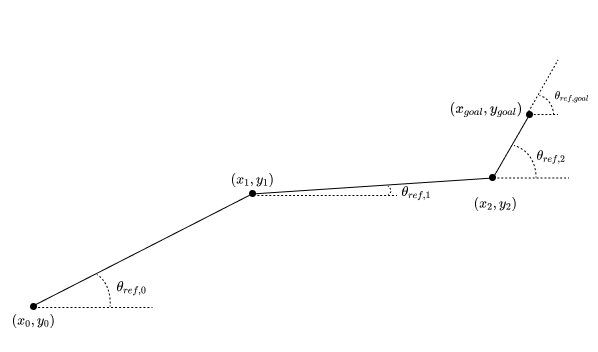

Now that we have our reference approach angles, we can proceed with motion control. Motion control is seperated into four states, given below in a hierarchical order. Note that, AVOIDANCE state only active when there is an obstacle. Otherwise, robot will be either in HEADING or ASTOLFI state. To decide which state should be active, current position is retrieved from Kalman Filter and subsequently controller decides the state of the Thymio.

* PASS : Stops the Thymio if current state cannot satisfy conditions of states above. 
* HEADING : Turns Thymio with a constant angular speed around its frame.
* ASTOLFI : Moves Thymio to next position with a constant linear velocity. This is the main controller part in which Astolfi controller is used
* AVOIDANCE : Steers robot to opposite direction of obstacle. 

At the initialization, robot starts at PASS state to avoid any undesired motion. Current state estimation is retrieved from Kalman and later polar coordinates are computed. Depending on the values obtained, state of Thymio is decided by the controller.

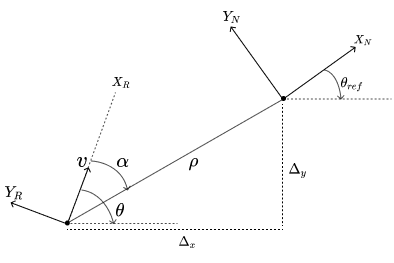

### Polar Coordinates and Astolfi Controller

Polar coordinates calculated as: 
\begin{equation*}
\rho = \sqrt(\Delta_x^2+\Delta_y^2) [cm]\\
\alpha = atan2(\Delta_y,\Delta_x) - \theta [rad]\\
\beta = -\alpha -\theta - \theta_{ref} [rad]\\
\end{equation*}
$\theta_{ref}$ is the only variable computed at the initialization of global trajectory for Thymio, but other variables will be computed in each iteration. 

To decide the states of Thymio, we use variables above. Astolfi Controller only works for $\alpha \in (-\pi/2,\pi/2]$ [1]. Furthermore, due to limitation of physical system, when $\alpha$ is near $\pi/2$, robot cannot move properly. Thus, as a safety margin we limited Astolfi controller for $\alpha \in (-\pi/4,\pi/4)$. If $|\alpha|>\pi/4$, Thymio enters HEADING state, otherwise the state is ASTOLFI when there is no obstacle.

#### HEADING State:
In the HEADING state, Thymio rotates around its own axis until $\alpha$ satisfies conditions above. For that, control variable choosen as $v=0,\enspace \omega=1 \text{ or } -1$ depending on the direction robot needs to turn. Then wheel speed obtained as:

$\dot\phi_L = -\frac{r\omega}{2L}$

$\dot\phi_R = \frac{r\omega}{2L}$

where L is the half axle length and r is the wheel radius. Whence Thymio satisfies $\alpha$ constraints, its state becomes ASTOLFI, where we move robot to next position.

#### ASTOLFI State:
Whence heading error $\alpha$ is within the range, motion will be decided by Astolfi Control Law. Control law of Astolfi is as follows:

$v=K_\rho \rho$

$\omega=K_\alpha \alpha + K_\beta \beta$

Moreover, for stability gains should satisfy $K_\rho>0$,$K_\beta<0$ and $K_\alpha-K_\rho>0$ constraints [1]. For this, $(K_\rho,K_\alpha,K_\beta)=(10,35,-1.5)$. Note that, these values are empirical values evolved from the initial gains of Astolfi $(3,8,-1.5)$ [1]. However, to obtain constant linear velocity, we have normalized control law by $\rho$ and obtained control law below.

$v=K_\rho,\quad$
$\omega=\frac{K_\alpha \alpha + K_\beta \beta}{\rho}$

In theory, this control law has a singularity point where $\rho=0$. But in practice, $\rho$ we can usually never reach our goal and/or trying to be exactly on goal is impractical. So, goal is assumed to be reached within a certain threshold, $\rho < 10 cm$. Since we have our control variables, we can calculate input variables $\dot\phi_L$ and $\dot\phi_R$.

$\dot\phi_L = \frac{v}{r} - \frac{\omega L}{r}$

$\dot\phi_R = \frac{v}{r}  + \frac{\omega L}{r}$

After obtaining input variables $\dot\phi$, we always check whether or not they exceed maximum allowable speed, which is not necessarily maximum speed of Thymio. Maximmum speed for controller is choosen as 4.5 rad/s.

#### AVOIDANCE State:
Before sending inputs to the Thymio, $\dot\phi_L$ and $\dot\phi_R$ are computed by Astolfi controller, there is an intermediary state decision in case there exists an obstacle along the trajectory. If one of the outer most front sensors detects a value, the state is changed to 'AVOIDANCE'. Whenever this state is activated, the speed of the thymio will be modified to ensure the obstacle will be avoided. Once both sensors do not detect anything, the state is changed back to the astolfi state. This is done by using the following equation for the left and right motor speed:

    left motor = speed0 + obstacle speed gain * (sensor value left// 100)
    right motor = speed0 + obstacle speed gain * (sensor value right// 100)
    
with speed0 chosen as 50 and the obstacle speed gain as 5. These values were found by iterating the process for multiple scenario's. 

## Results

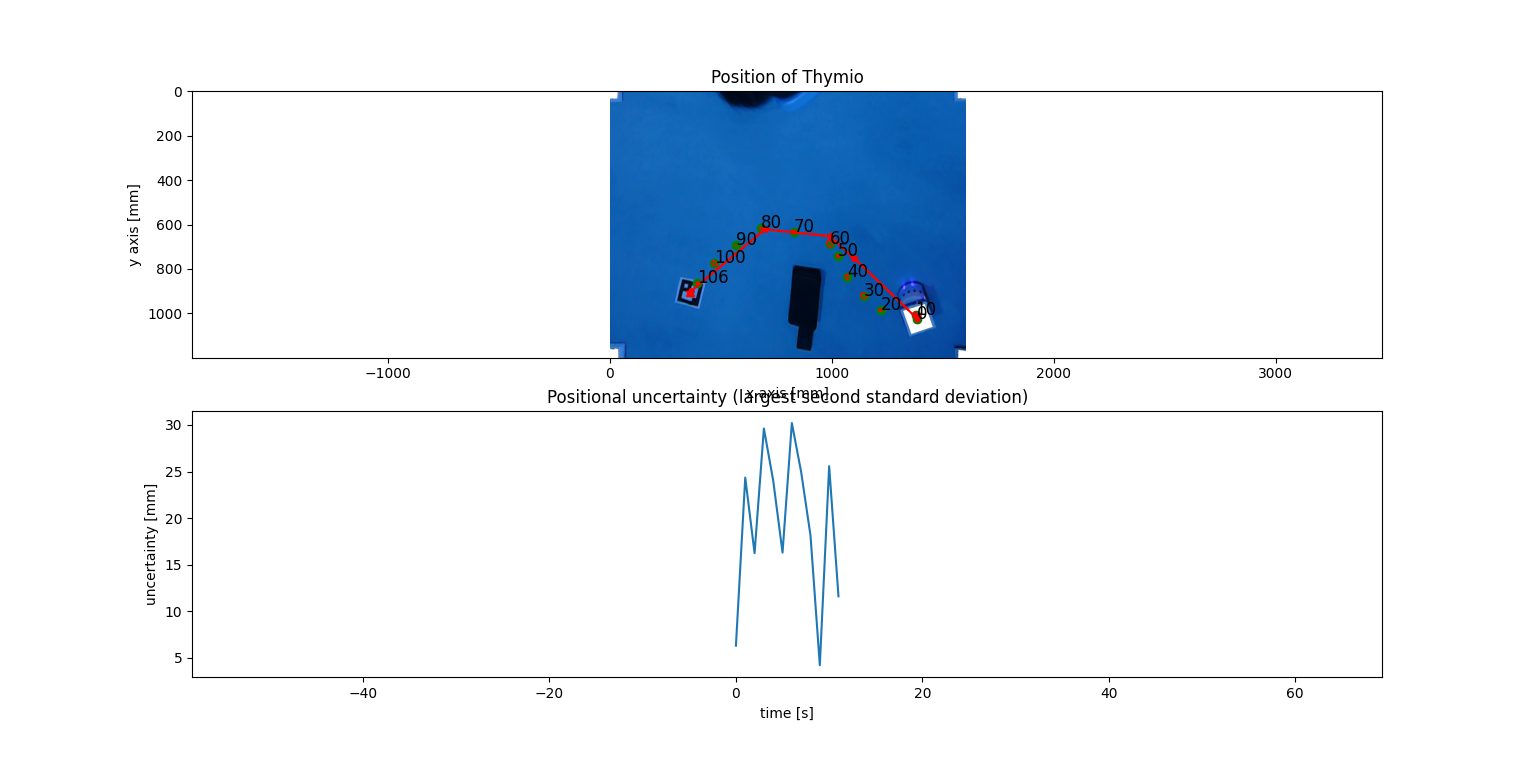

In the plot above there is on top an trajectory of Thymio going around one obstical towards the goal. The red line represents the optimal trajectory. The green points show the estimated position. They are numerized after the updating cycles from the motion controller. Around the estimated positions there are small red ellipses representing the uncertainty at this moment. On the bottom the development of the uncertainty is given in function of time.

In the beginning, a picture is taken with the webcam (background of the plot) and the optimal path around the obstical is calculated (red line). First, Thymio is a little bit off track but the motion controller leads him soon back to the optimal trajectory. Then, he stays on the optimal path and reaches the goal after 106 updating cycles. Four times the uncertainty becomes too high and a picture is taken which is seen by the four peaks on the bottom plot. Otherwise, the _Vision_ module is not used and Thymio runs only based on motor speed measurements. The local obstical avoidance is not needed in this example. It would have been triggered if an obstical would have been detected by the proximity sensors.

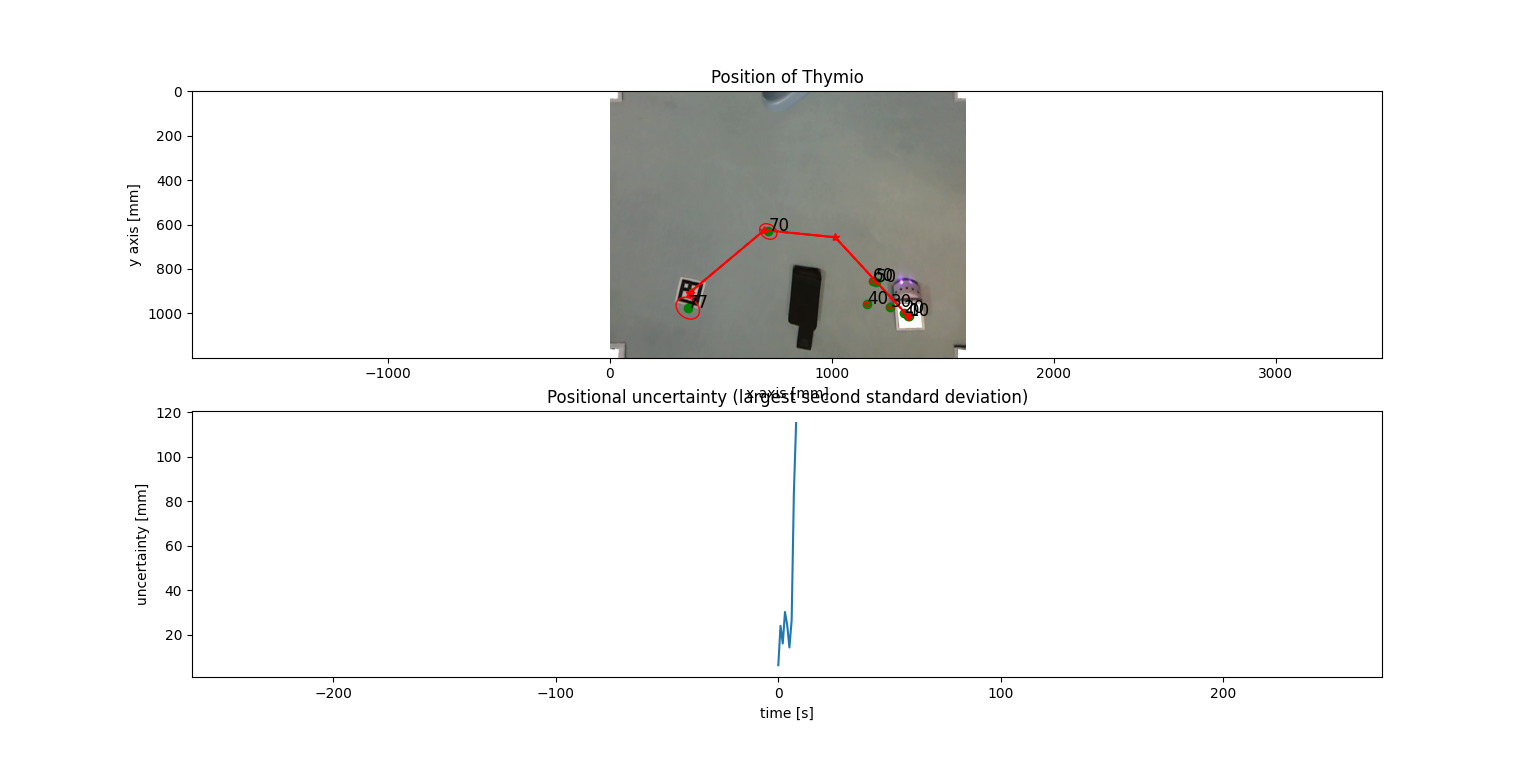

In the plot above the same trajectory was made as in the example discussed before. However, this time the camera was covered after Thymio found its initial position. If no good picture could been made Thymio will just continue its trajectory. However, the estimation is never correctified by a position measurement. Hence, the estimation from the kalman filter becomes much less precise. Thymio, thought that he reached the goal after 77 updating cycles. In reality, he was still approximately 20cm away from the destination. This shows that the program runs without any position correction from the _Vision_ part. Neverthelss, the performance becomes worse and for more complex environments Thymio would most probable collide with obsticals.